In [1]:
import torch
from torch import nn,optim
from torch.nn import functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import random

seed = np.random.randint(0,1000)

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)


In [2]:
display(torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

True

#Dataset Creation (MNIST)

In [3]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import torchvision.utils as vutils


batch_size = 128

transform = transforms.Compose([
                                transforms.Resize([64,64]),
                                transforms.ToTensor(),
                                transforms.Normalize(0,1)
                                ])

train_data = datasets.MNIST('data',train = True,download= True, transform = transform)

#Making output dir
!mkdir data/output

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [4]:
train_loader = DataLoader(dataset = train_data, batch_size = batch_size, num_workers=0)


#Image visualisation

In [5]:
def imshow(img):
    # img = img.numpy()
    i=0
    plt.imshow(np.transpose(img[0][i], (1, 2, 0)).squeeze())
    plt.title("Number is {}".format(img[1][i]))
    plt.axis("off")

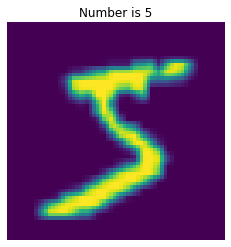

In [6]:
dataiter = iter(train_loader)
img = next(dataiter)

imshow(img)



#Defining the Architecture

###Generator

In [7]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator,self).__init__()

    self.lin = 100

    self.conv_g = nn.Sequential(
        nn.ConvTranspose2d(
            self.lin, 512, kernel_size = 4,
            stride = 1, padding = 0, bias = False),
        nn.BatchNorm2d(512),
        nn.ReLU(True),
        
        nn.ConvTranspose2d(
            512, 256, kernel_size = 4,
            stride = 2, padding = 1, bias = False),
        nn.BatchNorm2d(256),
        nn.ReLU(True),
        
        nn.ConvTranspose2d(
            256, 128, kernel_size = 4,
            stride = 2, padding = 1, bias = False),
        nn.BatchNorm2d(128),
        nn.ReLU(True),
        
        nn.ConvTranspose2d(
            128, 64, kernel_size = 4,
            stride = 2, padding = 1, bias = False),
        nn.BatchNorm2d(64),
        nn.ReLU(True),

        nn.ConvTranspose2d(
            64, 1, kernel_size = 4,
            stride = 2, padding = 1, bias = False),
        nn.Tanh()        
    )

  def forward(self,x):
    x = self.conv_g(x)
    return x


###Discriminator

In [8]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator,self).__init__()

    self.conv_d = nn.Sequential(
        nn.Conv2d(
            1, 64, kernel_size = 4,
            stride = 2, padding = 1, bias = False),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2,True),
        
        nn.Conv2d(
            64, 128, kernel_size = 4,
            stride = 2, padding = 1, bias = False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2,True),

        nn.Conv2d(
            128, 256, kernel_size = 4,
            stride = 2, padding = 1, bias = False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2,True),

        nn.Conv2d(
            256, 512, kernel_size = 4,
            stride = 2, padding = 1, bias = False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2,True),

        nn.Conv2d(
            512, 1, kernel_size = 4,
            stride = 1, padding = 0, bias = False),
        nn.Sigmoid()               
    )

  def forward(self,x):
    x = self.conv_d(x)
    return x

In [9]:
gen = Generator().to(device)
dis = Discriminator().to(device)

In [10]:
def initial_weights(net):
  classname = net.__class__.__name__

  if classname.find('Conv') != -1:
    nn.init.normal_(net.weight.data,0.0,0.02)
  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(net.weight.data,1.0,0.02)
    nn.init.constant_(net.bias.data,0)

In [11]:
gen.apply(initial_weights)
dis.apply(initial_weights)
print('#'*15 + " Generator " +'#'*15)
print(gen)
print('#'*41)

print("\n \n")
print('#'*15 + " Discriminator " +'#'*15)
print(dis)
print('#'*45)



############### Generator ###############
Generator(
  (conv_g): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding

#Optimizer, Loss and Parameters

In [12]:
lr = 0.0002
beta1 = 0.5
beta2 = 0.999
epochs = 20

opt_g = optim.Adam(gen.parameters(), lr = lr,betas = (beta1, beta2))

opt_d = optim.Adam(dis.parameters(), lr = lr,betas = (beta1, beta2))

crit = nn.BCELoss()



###Real and Fake Labels

In [13]:
def real_label(input_size):
  return torch.ones(input_size).to(device)

def fake_label(input_size):
  return torch.zeros(input_size).to(device)

def noise_tensor(sample_input,lin):
  return torch.randn(sample_input,lin,1,1).to(device)

fixed_noise = noise_tensor(64,100)
# display(noise)

#Training the Network

In [15]:
img_list = []
lossed_g = []
losses_d = []
iters = 0
nz = 100
print("Starting Training Loop...")
# For each epoch
for e in range(epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_loader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        dis.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.ones(b_size).to(device)
        # Forward pass real batch through D
        output_real = dis(real_cpu).view(-1)
        # Calculate loss on all-real batch
        loss_real = crit(output_real, label)
        # Calculate gradients for D in backward pass
        loss_real.backward()
        D_x = output_real.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, 100, 1, 1, device=device)
        # Generate fake image batch with G
        fake_data = gen(noise)
        label.fill_(0)
        # Classify all fake batch with D
        output = dis(fake_data.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        loss_fake = crit(output, label)
        # Calculate the gradients for this batch
        loss_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        loss_D = loss_real + loss_fake
        # Update D
        opt_d.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        gen.zero_grad()
        label.fill_(1)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = dis(fake_data).view(-1)
        # Calculate G's loss based on this output
        loss_g = crit(output, label)
        # Calculate gradients for G
        loss_g.backward()
        D_G_z2 = output.mean().item()
        # Update G
        opt_g.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (e, epochs, i, len(train_loader),
                     loss_d.item(), loss_g.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        lossed_g.append(loss_g.item())
        losses_d.append(loss_d.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((e == epochs-1) and (i == len(train_loader)-1)):
            with torch.no_grad():
                fake = gen(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

Starting Training Loop...
[0/20][0/469]	Loss_D: 0.0002	Loss_G: 10.1850	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[0/20][50/469]	Loss_D: 0.0002	Loss_G: 18.2470	D(x): 0.9900	D(G(z)): 0.0000 / 0.0000
[0/20][100/469]	Loss_D: 0.0002	Loss_G: 8.5382	D(x): 0.8700	D(G(z)): 0.0006 / 0.0003
[0/20][150/469]	Loss_D: 0.0002	Loss_G: 4.7109	D(x): 0.9245	D(G(z)): 0.0466 / 0.0144
[0/20][200/469]	Loss_D: 0.0002	Loss_G: 4.3919	D(x): 0.9573	D(G(z)): 0.0362 / 0.0175
[0/20][250/469]	Loss_D: 0.0002	Loss_G: 2.3745	D(x): 0.7734	D(G(z)): 0.0688 / 0.1516
[0/20][300/469]	Loss_D: 0.0002	Loss_G: 4.4834	D(x): 0.9409	D(G(z)): 0.0824 / 0.0177
[0/20][350/469]	Loss_D: 0.0002	Loss_G: 3.9504	D(x): 0.9626	D(G(z)): 0.0397 / 0.0282
[0/20][400/469]	Loss_D: 0.0002	Loss_G: 3.6771	D(x): 0.9533	D(G(z)): 0.1913 / 0.0351
[0/20][450/469]	Loss_D: 0.0002	Loss_G: 4.6623	D(x): 0.9838	D(G(z)): 0.1127 / 0.0132
[1/20][0/469]	Loss_D: 0.0002	Loss_G: 8.5000	D(x): 0.9920	D(G(z)): 0.6375 / 0.0081
[1/20][50/469]	Loss_D: 0.0002	Loss_G: 9.8585	D(x): 0.

#Visualisation of Trained Generator

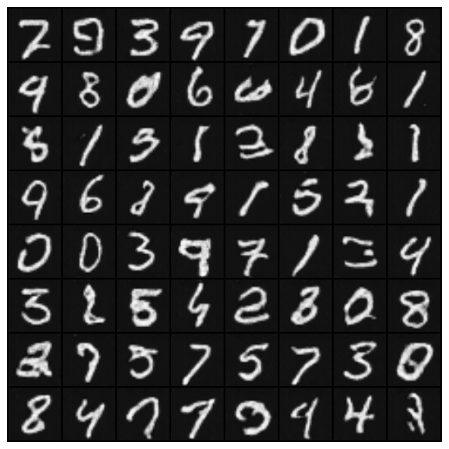

In [31]:
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(figsize=(8,8))
plt.axis("off")
slideshow = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, slideshow, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

##Loss vs Iteration

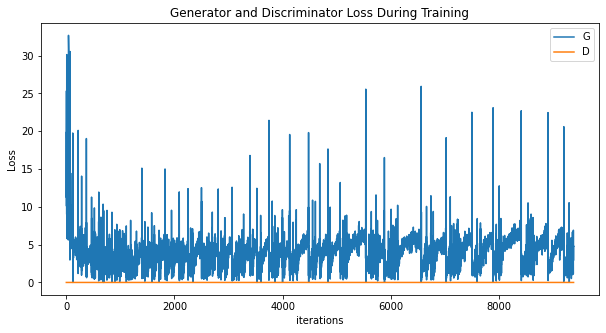

In [25]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(lossed_g,label="G")
plt.plot(losses_d,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()